In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle("data/bikes_limpieza.pkl")
df.head(2)

,fecha,estacion,año,mes,festivo,dia,laborable,meteo,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados,total_alquiler
0,2018-01-01,invierno,2018,ene,festivo,lun,no laborable,nublado,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2018-01-02,invierno,2018,ene,no festivo,mar,laborable,nublado,14.902598,17.68695,69.6087,16.652113,131,670,801


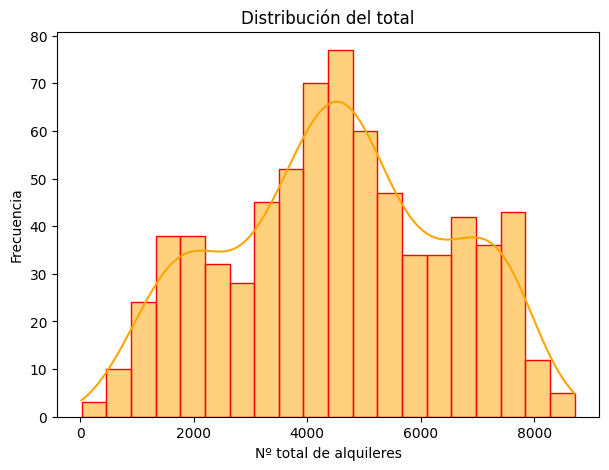

In [3]:
plt.figure(figsize=(7, 5))

sns.histplot(df["total_alquiler"], bins=20, color="orange", edgecolor="red", kde=True)

plt.title("Distribución del total")
plt.xlabel("Nº total de alquileres")
plt.ylabel("Frecuencia")
plt.show()   #distribución variable respuesta

`ESTO LO COMPROBAMOS AQUÍ O EN OTRO JUPYTER DE ASUNCIONES?`
A nivel visual, parece que nuestra VR no es normal. Vamos a comprobarlo con un Shapiro (nuestros datos son < 5000).

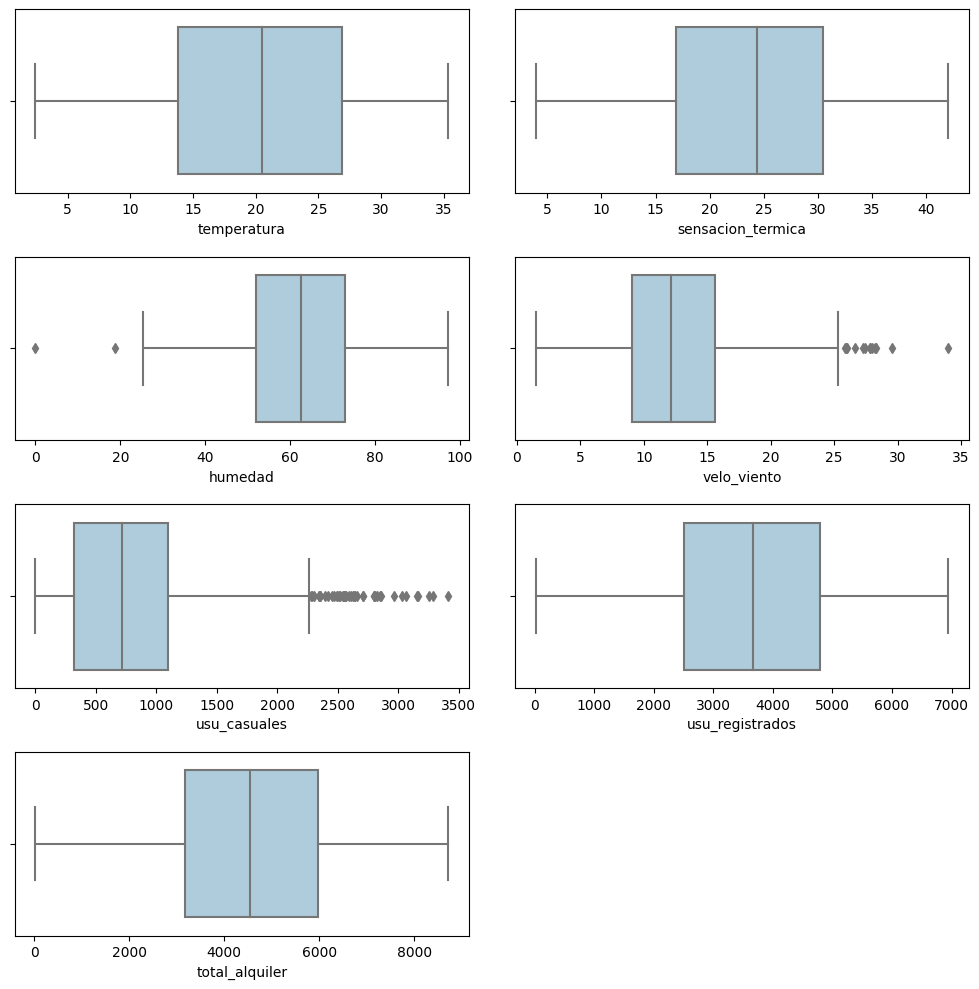

In [4]:
numericas = df.select_dtypes(include=['int64', 'float64'])

fig, axes = plt.subplots(4, 2, figsize=(10,10))
axes = axes.flat
for indice, columna in enumerate(numericas.columns):
    sns.boxplot(x = numericas[columna], data = df, ax = axes[indice], palette = "Paired");
plt.tight_layout()
fig.delaxes(axes[-1])
plt.show()    #chequeo de outliers

A la vista de los outliers, mantendríamos todos (por ser valores que parecen reales), salvo en el caso de "humedad" (hemos revisado que estos datos son extremadamente improbables). Vamos a ver quiénes son esos outliers:

In [7]:
df[df["humedad"] < 20]

,fecha,estacion,año,mes,festivo,dia,laborable,meteo,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados,total_alquiler
49,2018-02-19,invierno,2018,feb,festivo,lun,no laborable,buen tiempo,16.365847,19.5702,18.7917,34.000021,532,1103,1635
68,2018-03-10,invierno,2018,mar,no festivo,sab,no laborable,ligeramente mal tiempo,15.952731,19.2834,0.0000,17.545759,46,577,623


`ESTO SE NOS QUEDA PENDIENTE DE DEBATE`
A la vista de estos valores, hemos decidido reemplazar estos dos outliers por la temperatura mediana dentro de ese mismo mes de ese mismo año y para el mismo tipo de día (los datos de climatología histórica para Washington que hemos encontrado en internet no nos cuadraban con los del dataframe):
- En el caso del 2018-02-19, sacaremos la mediana de febrero de 2018 de días con buen tiempo (hay 19 registros).
- En el caso del 2018-03-10, sacaremos la mediana de marzo de 2018 de días con ligeramente mal tiempo (en este caso, además, la media y la mediana son las mismas).

`ESTE SERÍA EL CÓIDGO PARA EL REEMPLAZO`

In [ ]:
df[df[fecha] == "2018-02-19"]["humedad"] = df[(df["estacion"] == "invierno") & (df["meteo"] == "buen tiempo")]["humedad"].median()

In [ ]:
df[df[fecha] == "2018-03-10"]["humedad"] = df[(df["estacion"] == "invierno") & (df["meteo"] == "ligeramente mal tiempo")]["humedad"].median()

`ESTOS SON LOS DATOS (PARA QUE DEBATAMOS)`

In [50]:
df[(df["meteo"] == "buen tiempo")].groupby(["meteo", "año", "estacion"])["humedad"].agg(["mean", "median", "count"])

mean    median  count
meteo       año  estacion                             
buen tiempo 2018 invierno   51.208564  50.69570     55
                 otoño      63.085977  63.68750     52
                 primavera  57.687281  60.00000     53
                 verano     59.221244  58.77085     66
            2019 invierno   51.266906  50.76630     54
                 otoño      57.505649  56.83330     51
                 primavera  53.472710  51.39585     62
                 verano     58.679164  59.25000     70

In [46]:
df[(df["meteo"] == "ligeramente mal tiempo")].groupby(["meteo", "año", "estacion"])["humedad"].agg(["mean", "median", "count"])

mean    median  count
meteo                  año  estacion                             
ligeramente mal tiempo 2018 invierno   43.125000  43.12500      2
                            otoño      92.580838  92.00000      8
                            primavera  90.333300  90.33330      2
                            verano     91.453500  91.70830      3
                       2019 invierno   77.729150  77.72915      2
                            otoño      87.583350  87.58335      2
                            primavera  83.541700  83.54170      1
                            verano     86.541700  86.54170      1

In [30]:
df[(df["estacion"] == "invierno") & (df["meteo"] == "ligeramente mal tiempo")]

,fecha,estacion,año,mes,festivo,dia,laborable,meteo,temperatura,sensacion_termica,humedad,velo_viento,usu_casuales,usu_registrados,total_alquiler
25,2018-01-26,invierno,2018,ene,no festivo,vie,laborable,ligeramente mal tiempo,8.917500,10.18000,86.2500,19.687950,34,472,506
68,2018-03-10,invierno,2018,mar,no festivo,sab,no laborable,ligeramente mal tiempo,15.952731,19.28340,0.0000,17.545759,46,577,623
406,2019-02-11,invierno,2019,feb,no festivo,lun,laborable,ligeramente mal tiempo,9.190847,10.54335,73.1250,19.416332,192,1977,2169
724,2019-12-26,invierno,2019,dic,no festivo,jue,laborable,ligeramente mal tiempo,9.976653,11.01665,82.3333,21.208582,9,432,441


Vamos a comprobar las relaciones entre las VP numéricas y la VR:

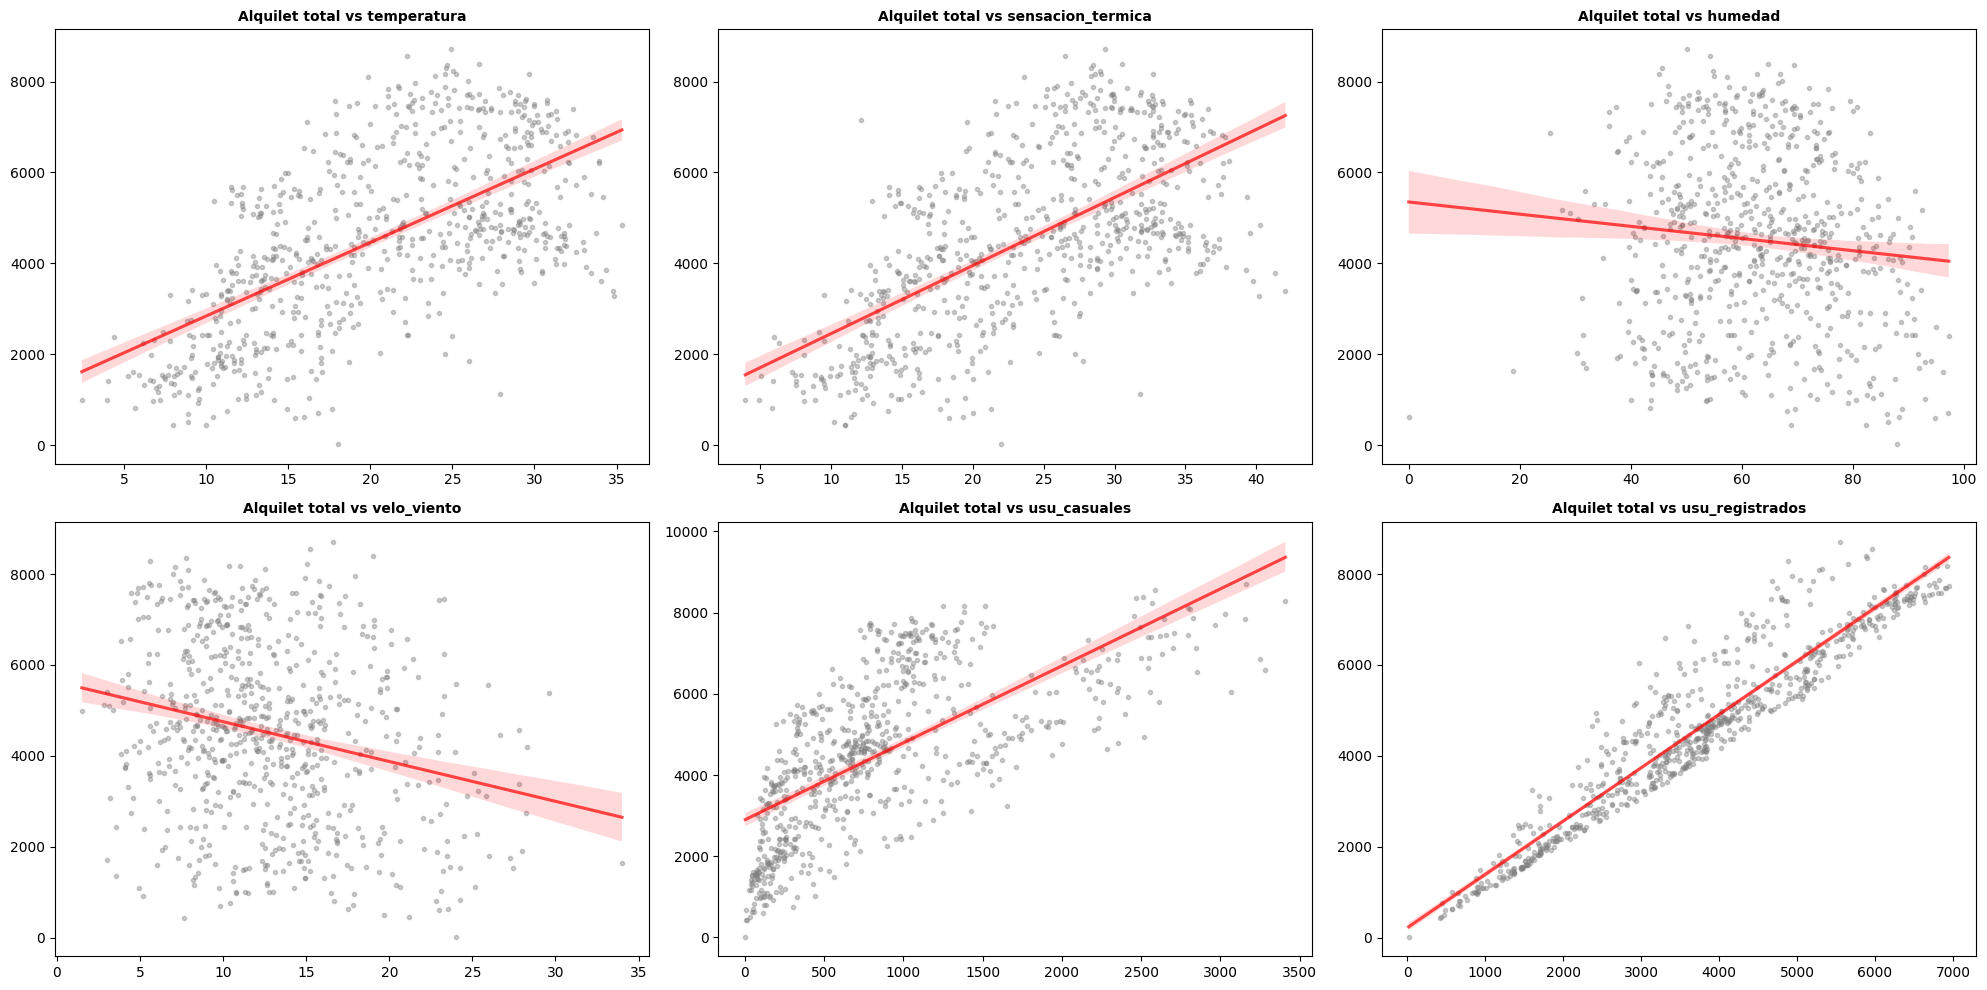

In [57]:
fig, axes = plt.subplots(2, 3, figsize = (20, 10))

axes = axes.flat

columnas_numeric = numericas.columns
columnas_numeric = columnas_numeric.drop("total_alquiler")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["total_alquiler"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Alquilet total vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();